Power Spectrum Analysis
======

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import PSC

Data

In [24]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.cuda.get_device_name(0))

lorenz_train=np.load("../data/lorenz_train.npy")
lorenz_test=np.load("../data/lorenz_test.npy")
print("Train data size: ",lorenz_train.shape)
print("Test data size: ",lorenz_test.shape)

def data_preperation(data):
    t=np.arange(0,len(data[0,:,0]))
    X_train=torch.from_numpy(data[:,0:-1,:]).float().to(device)
    Y_train=torch.from_numpy(data[:,1:,:]).float().to(device)
    return X_train,Y_train,t

X_train,Y_train,t = data_preperation(lorenz_train)
X_test,Y_test,t = data_preperation(lorenz_test)

Using cuda device
NVIDIA GeForce GTX 1070
Train data size:  (100, 1000, 3)
Test data size:  (100, 1000, 3)


Hyperparameter

In [25]:
SMOOTHING_SIGMA = 50
FREQUENCY_CUTOFF = 5000  # in 1/length

hidden_size = 20  # number of hidden units x RNN
input_size = len(lorenz_train[0,0,:])  # number of input units
output_size = len(lorenz_train[0,0,:])  # number of output units
num_layers = 1  # number of layers
batch_size = len(lorenz_train[:,0,0])  # size of the input data used for one iteration
criterion = nn.MSELoss()

Analysis
-------

LSTM model

In [26]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyRNN, self).__init__()  # Inherited from the parent class nn.Module
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)  # Define the output layer

    def forward(self, x):  # Forward pass: stacking each layer together

        output, hidden = self.lstm(x)
        output = self.linear(output)

        return output

Load trained model

In [27]:
model=torch.load('../model/LSTM_model_lorenz.pt')

Predict trajectory

In [28]:
def traj_prediction(traj_num,steps,ini_steps,X_test,Y_test,n=100):  # max steps 999
    ini=X_test[traj_num,n-ini_steps:n,:].reshape(1,ini_steps,input_size)
    x=torch.ones(1,ini_steps,input_size, dtype=torch.float).to(device)
    x=ini

    for j in range(steps): # Go over all future predictions

        y_pre = model(x)[:,-1,:].reshape(1,1,input_size) # get the predicted value which is one step ahead
        x=torch.cat((x,y_pre),axis=1) # Add the predicted value to the test set

    y=Y_test[traj_num,n:steps+n,:].reshape(1,steps,input_size)
    y_pred=x[0,ini_steps:ini_steps+steps,:].reshape(1,steps,input_size)
    loss= criterion(y_pred,y).item()

    return y.cpu().detach().numpy(),y_pred.cpu().detach().numpy(),ini.cpu().numpy(),loss

In [47]:
traj_num=0
steps=400
ini_steps=100

y,y_pred,x,loss=traj_prediction(traj_num,steps,ini_steps,X_test,Y_test)
print("MSE of predicted trajectory using a initial sequence: ",loss)
y_single,y_pred_single,_,loss_single=traj_prediction(traj_num,steps,1,X_test,Y_test)
print("MSE of predicted trajectory using single initial point: ",loss_single)

MSE of predicted trajectory using a initial sequence:  0.005210054572671652
MSE of predicted trajectory using single initial point:  0.9653140306472778


Power spectrum error

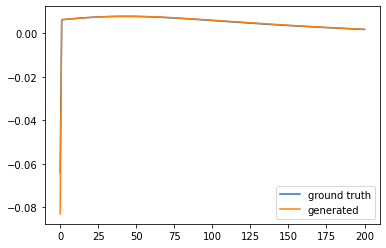

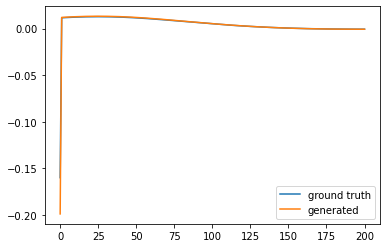

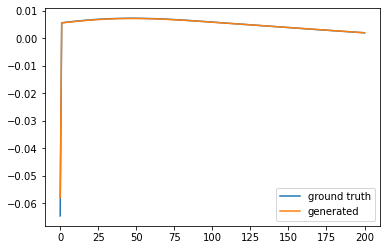

In [48]:
power=PSC.power_spectrum_error_per_dim(y,y_pred)

In [49]:
print("Power spectrum error for each dimension: ",power)
print("Mean spectrum power error: ",np.mean(power))

Power spectrum error for each dimension:  [0.9968717265417315, 0.9982537455332449, 0.9997196613945467]
Mean spectrum power error:  0.9982817111565078


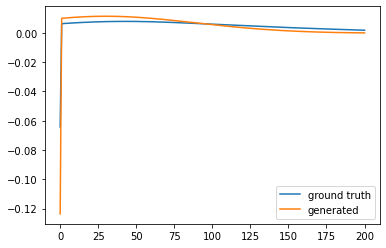

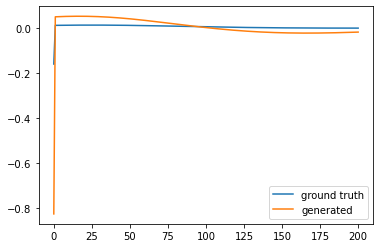

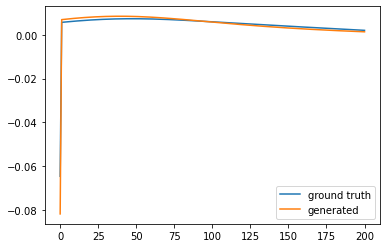

In [50]:
power=PSC.power_spectrum_error_per_dim(y_single,y_pred_single)

In [51]:
print("Power spectrum error for each dimension: ",power)
print("Mean spectrum power error: ",np.mean(power))

Power spectrum error for each dimension:  [0.9939413729502391, 0.9976029238664249, 0.9968973519931553]
Mean spectrum power error:  0.9961472162699397
